# Met Eireann wind speed analysis
## Programming for Data Analytics Project
Author: Vanessa de Oliveira Lyra


Met Éireann weather stations close to Wind Farms in Ireland with wind speed data available:  
- Mace Head (Galway)  
- Malin Head (Donegal)  
- Ireland West Knock Airport (Mayo)  
- Gurteen (Tipperary)     

References:  
Weather stations and data: https://www.met.ie/climate/available-data/historical-data  
Weather stations proximity to Wind farms: https://chatgpt.com/share/695583bd-1238-8006-ac31-fcac77086ace

### Importing libraries

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sb
import numpy as np
from windrose import WindroseAxes
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Database connection

In [33]:
# Connecting to SQLite and creating database file
conn = sqlite3.connect("windspeed.db")

### Fetching data and dataset exploratory analysis:

Daily data files

In [34]:
# Mapping CSV filepaths
weather_files = {
    "mace": "datasets/dly275_mace_head.csv",
    "malin": "datasets/dly1575_malin_head.csv",
    "knock": "datasets/dly4935_knock_airport.csv",
    "gurteen": "datasets/dly1475_gurteen.csv",
    }

# Dictionary to store data
df_weather = {}

# For loop to read CSV files
for key, value in weather_files.items():
    df_weather[key] = pd.read_csv(value, skiprows=24) 

In [35]:
# Displaying first 5 rows of data for reference
df_weather["mace"].head()

,date,ind,maxtp,ind.1,mintp,igmin,gmin,ind.2,rain,cbl,...,ddhm,ind.5,hg,soil,pe,evap,smd_wd,smd_md,smd_pd,glorad
0,14-aug-2003,0,19.2,0,9.0,,,0,0.0,1020.2,...,60,0,17,,,,,,,2432
1,15-aug-2003,0,19.3,0,11.2,,,0,0.0,1018.7,...,280,0,15,,,,,,,2284
2,16-aug-2003,0,19.4,0,11.0,,,0,0.0,1015.6,...,200,0,13,,,,,,,2084
3,17-aug-2003,0,17.0,0,14.4,,,0,3.3,1008.3,...,180,0,34,,,,,,,954
4,18-aug-2003,0,17.1,0,13.1,,,0,0.2,1011.9,...,270,0,28,,,,,,,1225


In [36]:
# Displaying data types and structure 
df_weather["mace"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8093 entries, 0 to 8092
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    8093 non-null   object
 1   ind     8093 non-null   int64 
 2   maxtp   8093 non-null   object
 3   ind.1   8093 non-null   int64 
 4   mintp   8093 non-null   object
 5   igmin   8093 non-null   object
 6   gmin    8093 non-null   object
 7   ind.2   8093 non-null   int64 
 8   rain    8093 non-null   object
 9   cbl     8093 non-null   object
 10  wdsp    8093 non-null   object
 11  ind.3   8093 non-null   int64 
 12  hm      8093 non-null   object
 13  ind.4   8093 non-null   int64 
 14  ddhm    8093 non-null   object
 15  ind.5   8093 non-null   int64 
 16  hg      8093 non-null   object
 17  soil    8093 non-null   object
 18  pe      8093 non-null   object
 19  evap    8093 non-null   object
 20  smd_wd  8093 non-null   object
 21  smd_md  8093 non-null   object
 22  smd_pd  8093 non-null   

Date column is stored as object, convert to Datetime. Dates stored as DD-MM-YYYY  
Convert columns rain, wdsp, hm, ddhm and hg to integer.

Hourly data files

In [37]:
# Mapping CSV filepaths
weather_hly_files = {
    "mace_hly": "datasets/hly275_mace_head.csv",
    "malin_hly": "datasets/hly1575_malin_head.csv",
    "knock_hly": "datasets/hly4935_knock_airport.csv",
    "gurteen_hly": "datasets/hly1475_gurteen.csv"}    

# Dictionary to store data
df_weather_hly = {}

# For loop to read CSV files
# Stations with header on line 18
for key in ["mace_hly", "gurteen_hly"]:
    df_weather_hly[key] = pd.read_csv(weather_hly_files[key], skiprows=17,low_memory=False)

# Stations with header on line 24
for key in ["malin_hly", "knock_hly"]:
    df_weather_hly[key] = pd.read_csv(weather_hly_files[key], skiprows=23,low_memory=False)

In [38]:
# Displaying first 5 rows of data for reference
df_weather_hly["mace_hly"].head()

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl,ind.3,wdsp,ind.4,wddir
0,13-aug-2003 01:00,-1,,4,,4,,,,,,7,,7,
1,13-aug-2003 02:00,-1,,4,,4,,,,,,7,,7,
2,13-aug-2003 03:00,-1,,4,,4,,,,,,7,,7,
3,13-aug-2003 04:00,-1,,4,,4,,,,,,7,,7,
4,13-aug-2003 05:00,-1,,4,,4,,,,,,7,,7,


In [39]:
# Displaying data types and structure 
df_weather_hly["mace_hly"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195504 entries, 0 to 195503
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    195504 non-null  object
 1   ind     195504 non-null  int64 
 2   rain    195504 non-null  object
 3   ind.1   195504 non-null  int64 
 4   temp    195504 non-null  object
 5   ind.2   195504 non-null  int64 
 6   wetb    195504 non-null  object
 7   dewpt   195504 non-null  object
 8   vappr   195504 non-null  object
 9   rhum    195504 non-null  object
 10  msl     195504 non-null  object
 11  ind.3   195504 non-null  int64 
 12  wdsp    195504 non-null  object
 13  ind.4   195504 non-null  int64 
 14  wddir   195504 non-null  object
dtypes: int64(5), object(10)
memory usage: 22.4+ MB


Date column is stored as object, convert to Datetime. Dates stored as DD-MM-YYYY HH-MM
Convert columns rain, temp, wdsp and wwdir to integer.

##### References:
Skiprows function: https://stackoverflow.com/questions/20637439/skip-rows-during-csv-import-pandas   
Writing data to SQLite: https://stackoverflow.com/questions/14431646/how-to-write-pandas-dataframe-to-sqlite-with-index  
Importing multiple files: https://stackoverflow.com/questions/56155629/reading-multiple-csv-files-with-different-names-using-python-dictionary-in-a-for  
Low_memory from error: Columns (2,10,12,14,15,16,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False  
Dataset exploratory analysis: https://milvus.io/ai-quick-reference/how-do-i-analyze-and-visualize-a-dataset

### Cleaning up dataset data

Daily data files

In [40]:
# List of columns from dataset to be dropped
drop_columns = ["ind","ind.1","igmin","gmin","ind.2","ind.3","ind.4","ind.5","sun","dos","soil","pe","evap","smd_wd","smd_md","smd_pd","glorad"]

# Loop over all stations
for weather_files, df in df_weather.items():
    # Drop unwanted columns
    df.drop(columns=drop_columns, inplace=True, errors="ignore")
    
    # Normalizing date column
    # Removing white spaces from data using strip function
    # Converting data to datetime, coerce will replace any invalid dates with NaT
    df["date"] = df["date"].astype(str).str.strip()
    df["date"] = pd.to_datetime(df["date"], format="%d-%b-%Y", errors="coerce")
    
    # Convert dataset columns to numeric values using for loop
    for col in ["wdsp", "hm", "hg", "ddhm","rain","maxtp","mintp","cbl"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    
    # Update the dictionary with the cleaned data
    df_weather[weather_files] = df
    
    # Writing clean data to database, if data already exists, it will the replaced
    df.to_sql(f"{weather_files}_data", conn, if_exists="replace", index=False)

# Example: print Mace head after cleaning
# print(df_weather["mace"].head())

Hourly data files

In [41]:
# List of columns from dataset to be dropped
drop_columns = ["ind","ind.1","ind.2","ind.3","ind.4","wetb","dewpt","vappr","rhum","msl","ind.5","ind.6","ww","w","sun","vis","clht","clamt"]

# Loop over all stations
for weather_hly_files, df in df_weather_hly.items():
    # Drop unwanted columns
    df.drop(columns=drop_columns, inplace=True, errors="ignore")
    
    # Normalizing date column
    # Removing white spaces from data using strip()
    # Converting data to datetime, coerce will replace any invalid dates with NaT
    df["date"] = df["date"].astype(str).str.strip()
    df["date"] = pd.to_datetime(df["date"], format="%d-%b-%Y %H:%M", errors="coerce")
    
    # Convert dataset columns to numeric values using for loop
    for col in ["wdsp", "temp", "wddir","rain"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    
    # Update the dictionary with the cleaned data
    df_weather_hly[weather_hly_files] = df
    
    # Writing clean data to database
    df.to_sql(f"{weather_hly_files}_data", conn, if_exists="replace", index=False)

# Example: print Mace head after cleaning
# print(df_weather_hly["mace_hly"].head())

##### References
Remove white spaces from date: https://medium.com/@amit25173/how-to-remove-whitespace-from-strings-in-pandas-bfd9acdc55f3  
Converting datetime: https://pbpython.com/pandas_dtypes.html  
Convert data to numeric values: https://kajodata.com/en/knowledge-base-excel-sql-python/knowledge-base-python-tech-skillshow-pandas-to_numeric-works-in-python-examples-mmk/  
Dates showing as NaT after cleaning data, updated date format from %d-%b-%y to %d-%b-%Y to handle 4-digits year: https://medium.com/@codecorecomputercenter/python-date-formats-a-comprehensive-guide-c6ed0224980b     
For loop convert columns to numeric: https://stackoverflow.com/questions/50456153/use-to-numeric-on-certain-columns-only-in-pandas  

### Station names and labels

In [42]:
# List of stations to be analysed
all_stations = ["mace", "malin", "knock", "gurteen"]
all_stations_hly = ["mace_hly", "malin_hly","knock_hly", "gurteen_hly"]
labels = ["Mace", "Malin", "Knock Airport", "Gurteen"]

### Wind Power calculation

Formula: $P (W) = \frac{1}{2} \, \rho \, v^3$

Where:  
ρ = density of the air 1.225 kg/m3  
v = velocity of the wind in m/s 

In [43]:
# Daily data.Converting wind speed and calculating wind power
for key in all_stations:
    df = df_weather[key]

    # Converting wind speed from knots to m/s
    df["ms_wdsp"] = df["wdsp"] * 0.51444
    
    # Calculating wind power for each station
    df["wind_power"] = (0.5 * 1.255 * (df["ms_wdsp"] ** 3))

    # Saving data to SQL, getting file name, if table already exists it will be replaced
    df.to_sql(f"{key}_data",conn, if_exists="replace", index = False)

In [44]:
# Hourly data.Converting wind speed and calculating wind power
for key in all_stations_hly:
    df = df_weather_hly[key]

    # Converting wind speed from knots to m/s
    df["ms_wdsp"] = df["wdsp"] * 0.51444
    
    # Calculating wind power for each station
    df["wind_power"] = (0.5 * 1.255 * (df["ms_wdsp"] ** 3))

    # Saving data to SQL, getting file name, if table already exists is will be replaced
    df.to_sql(f"{key}_data",conn, if_exists="replace", index = False)

##### References: 
Convert winds peed to m/s: https://datascience.stackexchange.com/questions/131732/wind-power-data-analysis-pythonhttps://datascience.stackexchange.com/questions/131732/wind-power-data-analysis-python  
Wind power calculation: https://vortexfdc.com/blog/from-weibull-to-wind-parameters/

### Station Wind Speed Statistics

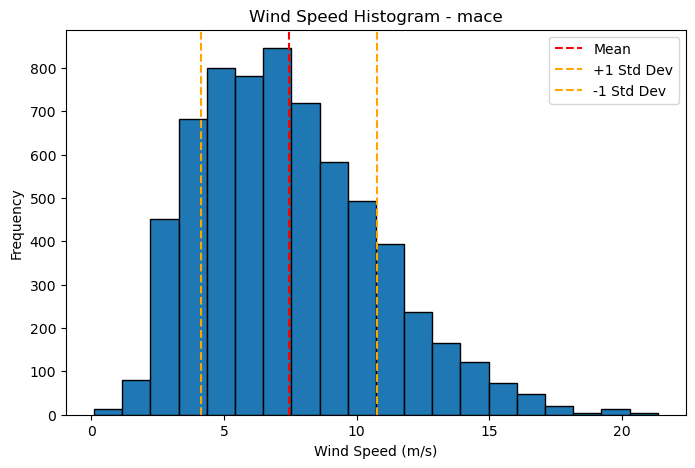

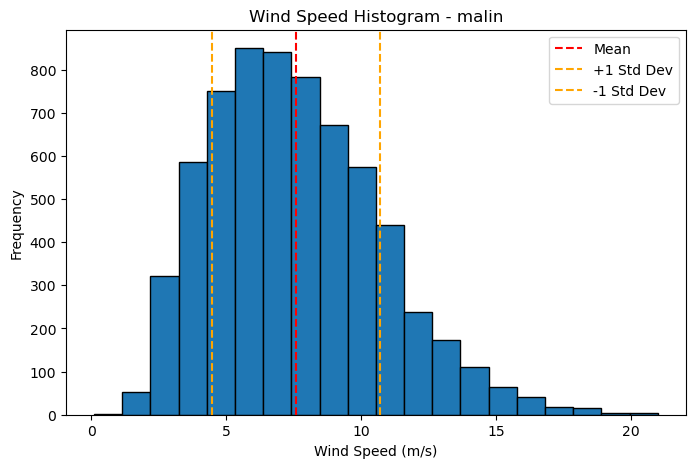

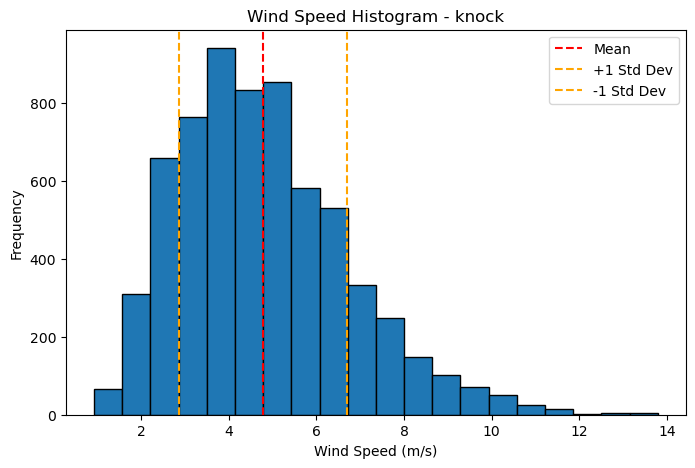

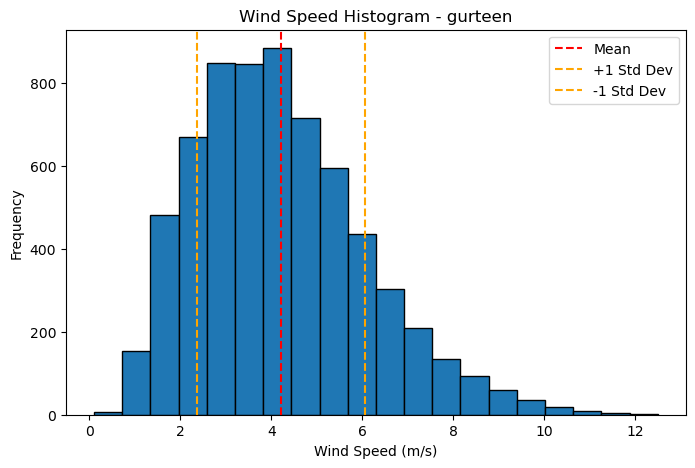

In [45]:
# Variable to store stats to be used later
wind_stats = []

# Looping through stations
for key in all_stations:
   # Retrieving DF for the station
   df = df_weather[key]

   # Filtering data by year for better comparison
   df_2008 = df[df["date"].dt.year >= 2008]

   # Getting stats for wind speed
   stats = df_2008["ms_wdsp"].describe()

   # Adding station to stats
   stats["station"] = key

   # Appending results to stats
   wind_stats.append(stats)

   # Acessing Mean and value variable for plotting    
   mean_value = stats["mean"]
   std_value = stats["std"]

   # Plot size:
   plt.figure(figsize=(8,5))

   # Plotting histogram with mean and +-1 deviation
   plt.hist(df_2008["ms_wdsp"], bins=20, edgecolor='black')
   plt.axvline(mean_value, color='red', linestyle='--', label='Mean') # Mean value (red dotted line)
   plt.axvline(mean_value + std_value, color='orange', linestyle='--', label='+1 Std Dev') # +1 Deviation (orange dotted line)
   plt.axvline(mean_value - std_value, color='orange', linestyle='--', label='-1 Std Dev') # -1 Deviation (orange dotted line)
    
   # Plotting data
   plt.title(f'Wind Speed Histogram - {key}')
   plt.xlabel('Wind Speed (m/s)')
   plt.ylabel('Frequency')
   plt.legend(loc='upper right')
   plt.show()

# Creating a dataframe for stats and setting station as index
stats_df = pd.DataFrame(wind_stats).set_index("station")

Since Gurteen's weather reports are only available from 2008, the analysis was restricted from 2008 onwards to ensure similar frequency across all sites. 

**Mace Head & Malin Head:**  
Both histograms shows a well-spread wide range of wind speeds, there is a clear concentration of medium and high wind speeds. Average wind speed is around 7.4 and 7.5 m/s respectively, and highest frequencies between 4 and 10 m/s. The spread of the distribution shows that the wind speeds vary regularly and the high average indicates these are both windy locations, the wind is frequently strong and low wind conditions are relatively rare. Both very favorable to Wind farms.

**Ireland West Knock Airport:**    
Knock's histogram is slightly narrower than the previous two, with average wind speed of 4.7 m/s, and highest frequencies between 4 and 6 m/s. Higher wind speeds are less frequent, not a location with strong wind but windy enough to support wind farms.

**Gurteen:**    
The average wind speed is relatively low, around 4.2 m/s. The histogram shows a mixed distribution, with mostly low wind speeds and but with a fair frequency. High wind speeds are very rare, the histogram is shifted to low wind range. The location is not consistently windy, but can somewhat support wind farms.

##### References

Filtering df.describe: https://stackoverflow.com/questions/19124148/modify-output-from-python-pandas-describe  
Concatenating statistics: https://pandas.pydata.org/docs/user_guide/merging.html  
Removing extra column "wdsp" from final table: https://stackoverflow.com/questions/22233488/pandas-drop-a-level-from-a-multi-level-column-index  
Rounding column values: https://stackoverflow.com/questions/26133538/round-a-single-column-in-pandas  
Histogram, mean and deviation plot: https://dev.to/jumashafara/descriptive-statistics-1g1e#:~:text=Standard%20Deviation:%20It%20is%20the,Note!

### Hourly windspeed patterns (in m/s)

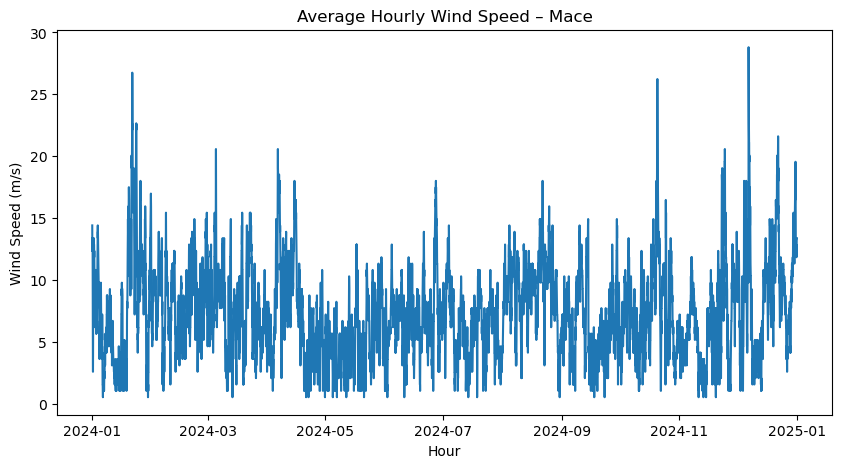

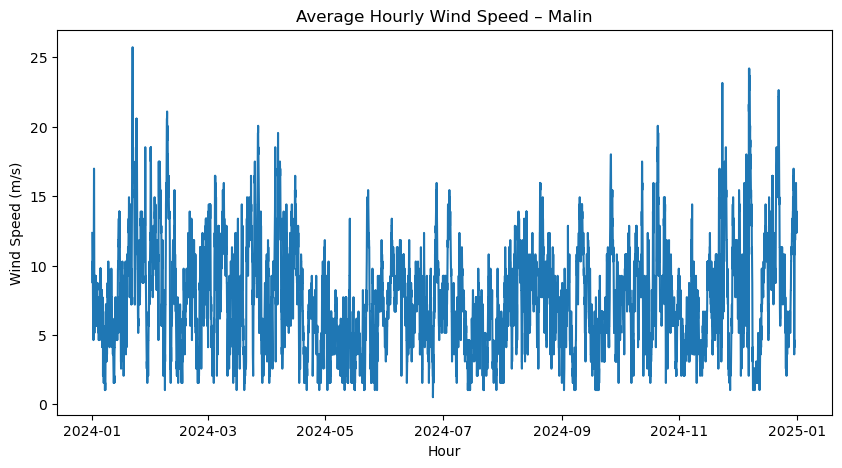

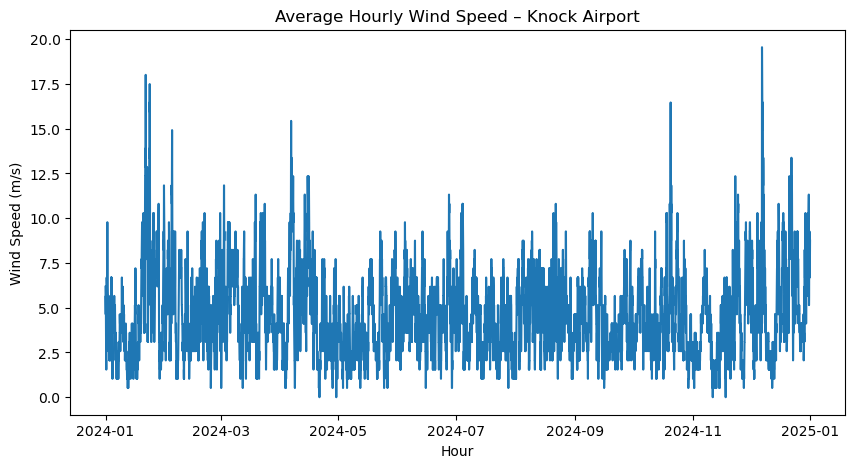

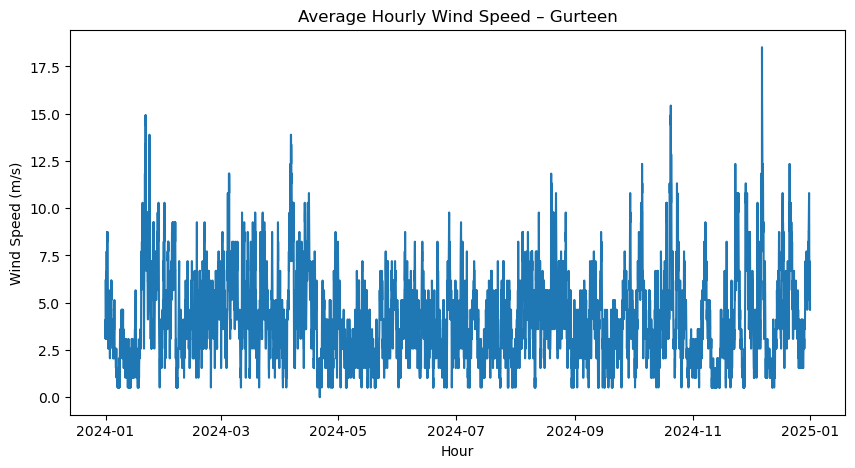

In [46]:
# Loop through stations
for i in range(len(all_stations_hly)): #Loop throught the length of the data, number of times to loop through
    station = all_stations_hly[i] # Get the weather station at a determined position, first loop will fetch data from position 0 and on
    label = labels[i] # Same as above but with labels
    
    # Filtering data from year 2024
    df_2024 = df_weather_hly[station][df_weather_hly[station]["date"].dt.year == 2024]
    
    # Grouping date and wind speed and calculating mean hourly wind speed 
    hourly_mean = df_2024.groupby(df_2024["date"])["ms_wdsp"].mean()
    
    # Plot size:
    plt.figure(figsize=(10,5))
    
    # Ploting results
    plt.plot(hourly_mean, label=label)

    # Printstatement for testing
    # print(monthly_mean)

    # Adding legend, title, and axis labels
    plt.title(f"Average Hourly Wind Speed – {label}")
    plt.xlabel("Hour")
    plt.ylabel("Wind Speed (m/s)")
    plt.show()

Year 2024 chosen for analysis.

**Some pattern visible across locations:**  
Winds are stronger during Winter and weaker during Summer.
Wind speeds significantly change on a hourly basis.
Calm and strong winds are often seen within a day.

Considering operational wind speeds for wind farms to be between cut-in 3 m/s and cut-out 25m/s:

**Mace Head & Malin Head:**  
The wind is strong and persistent it is possible to see long periods of operational wind speeds and rare drops below cut-in, turbines can operate almost continuously. Very strong winds above cut-out are rare but occur in Winter. 

**Ireland West Knock Airport:**  
Wind patterns are not as strong but stay mostly above cut-in often between 4 to 7 m/s, summer winds are noticeably less variable and calmer. Winds below cut-in are more frequent so causing some downtime as turbines occasionally stop. No records of winds above cut-out.

**Gurteen:**  
 The daily wind speed is low and inconsistent. Occasional short wind bursts seen and no winds above cut-out recorded. Wind speed variation is lower than other locations. Frequent calm winds below cut-in, cause frequent downtime.

### Monthly windspeed patterns (in m/s)

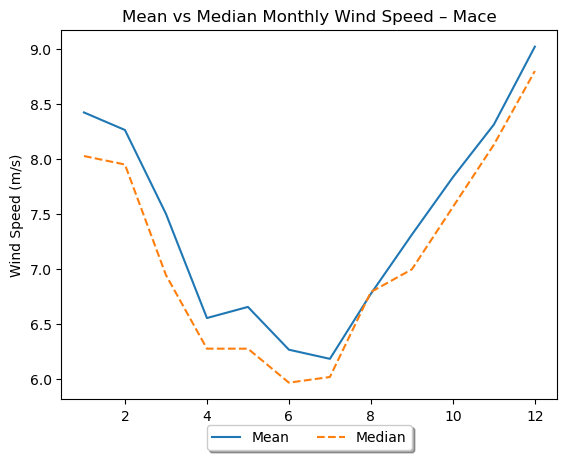

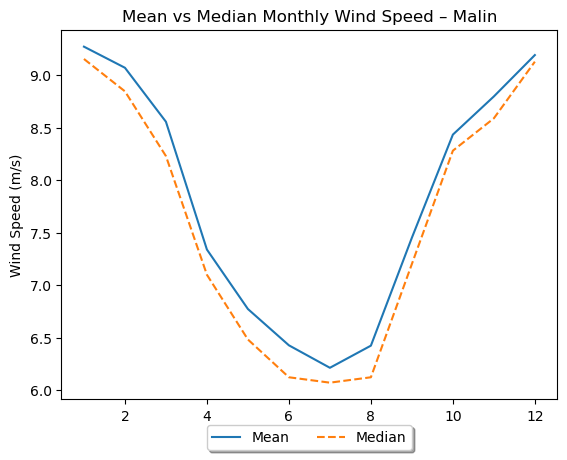

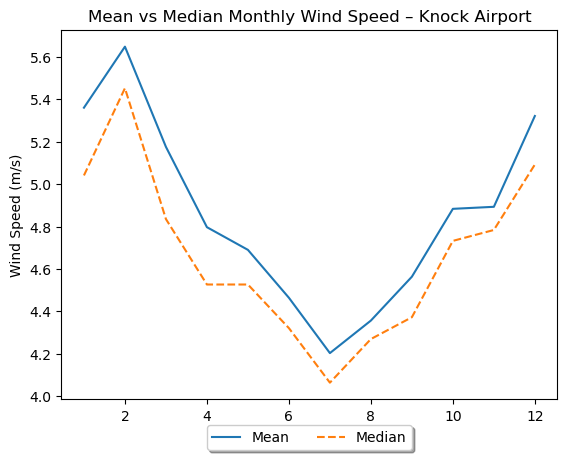

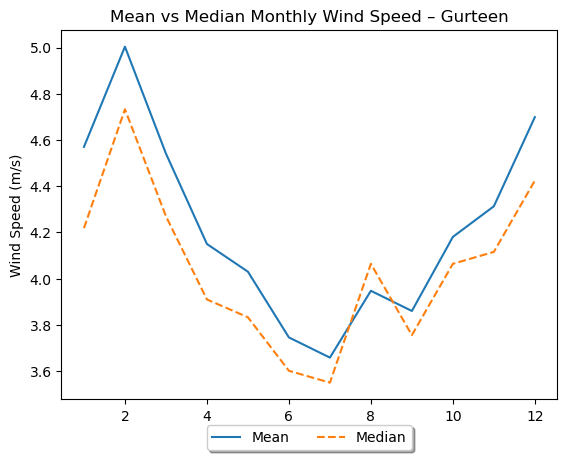


 Monthly mean and delta between mean and median wind speeds
    Month  Mace Mean  Mace Delta  Malin Mean  Malin Delta  Knock Airport Mean  \
0       1        8.4         0.4         9.3          0.1                 5.4   
1       2        8.3         0.3         9.1          0.2                 5.6   
2       3        7.5         0.6         8.6          0.3                 5.2   
3       4        6.6         0.3         7.3          0.2                 4.8   
4       5        6.7         0.4         6.8          0.3                 4.7   
5       6        6.3         0.3         6.4          0.3                 4.5   
6       7        6.2         0.2         6.2          0.1                 4.2   
7       8        6.8        -0.0         6.4          0.3                 4.4   
8       9        7.3         0.3         7.5          0.3                 4.6   
9      10        7.8         0.3         8.4          0.2                 4.9   
10     11        8.3         0.2         8.8    

In [47]:
# Variable to store means and medians
means_medians = []

# Loop through stations
for i in range(len(all_stations)):
    station = all_stations[i] 
    label = labels[i] 
    
    # Grouping date and wind speed and calculating mean and median for monthly wind speed
    monthly_mean = df_weather[station].groupby(df_weather[station]["date"].dt.month)["ms_wdsp"].mean()
    monthly_median = df_weather[station].groupby(df_weather[station]["date"].dt.month)["ms_wdsp"].median()

    # Calculating difference between mean and median
    monthly_diff = monthly_mean - monthly_median

    # Storing results in a dataframe
    monthly_table = pd.DataFrame({f"{label} Mean": monthly_mean,f"{label} Delta": monthly_diff})

    # Appending resulte to means_medians list
    means_medians.append(monthly_table)

    # Ploting results
    plt.plot(monthly_mean, label="Mean")
    plt.plot(monthly_median, linestyle="--",label="Median")

    # Printstatement for testing
    # print(monthly_mean)

    # Adding legend, title, and axis labels
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5) # Definign legend location
    plt.title(f"Mean vs Median Monthly Wind Speed – {label}")
    plt.xlabel("Month")
    plt.ylabel("Wind Speed (m/s)")
    plt.show()

# Concatenenating results side by side with axis = 1
diff_table = pd.concat(means_medians, axis=1)

# Reset index in month column to align headers
diff_table = diff_table.reset_index().rename(columns={"date": "Month"})

# Print table
print("\n Monthly mean and delta between mean and median wind speeds")
print(diff_table.round(1))

The monthly plots clearly show the significant wind speed difference between Winter and Summer.

**Mean vs median:**   
The differences between both are small - generally under 0.5 m/s, storms (very strong winds) do not look to affect averages significantly. The mean wind speed provides a good representation of actual wind conditions and it is considered for this analysis.

**Mace Head & Malin Head:**  
For both locations, the calm summer winds remain above 6 m/s. During winter, Mace's wind speed remains above 8 m/s and Malin's winds are stronger overall, above 9 m/s. Both show reliable operation during the year, with increased energy production during winter.

**Ireland West Knock Airport:**    
The month with lowest wind speed is July, but mean remain above cut-in. Highest is February at 5.6 m/s. Wind speeds are lower then the previous locations, wind speed variation also at lower range from 4.2 to 5.6 m/s. The plot implies turbine operation at reduced capacity during Summer, since average is close to cut-in.

**Gurteen:**    
Gurteen's wind speed patterns are even lower then Knock's, winds range from 3.7 to 5 m/s, Summer months wind speed remain below 4 m/s. The numbers indicate turbines working at reduced capacity and at minimal capacity during Summer.

### Yearly windspeed patterns (in m/s)

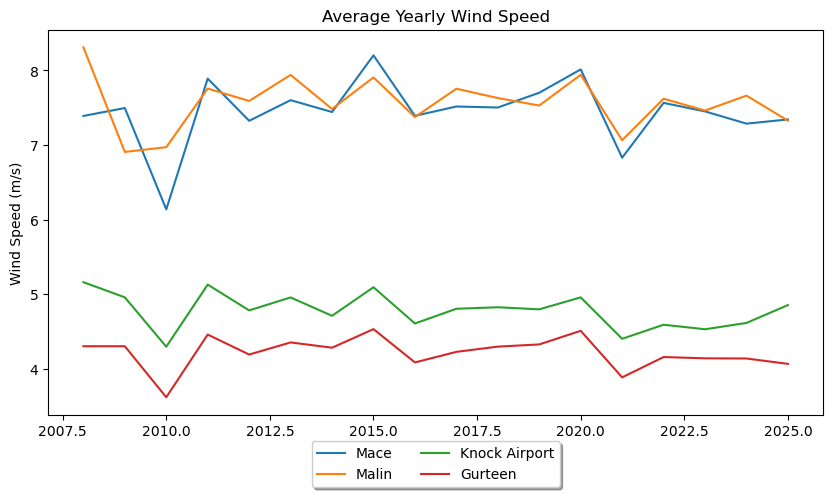

In [48]:
# Plot size:
plt.figure(figsize=(10,5))

# Loop through stations
for i in range(len(all_stations)): 
    station = all_stations[i] 
    label = labels[i] 
    
    # Filtering data from year 2008 
    df_2008 = df_weather[station][df_weather[station]["date"].dt.year >= 2008]
    
    # Grouping date and wind speed and calculating mean yearly wind speed 
    yearly_mean = df_2008.groupby(df_2008["date"].dt.year)["ms_wdsp"].mean()
    
    # Ploting results
    plt.plot(yearly_mean, label=label)

# Adding legend, title, and axis labels
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=2)
plt.title("Average Yearly Wind Speed")
plt.xlabel("Year")
plt.ylabel("Wind Speed (m/s)")
plt.show()

Analysis was restricted from 2008 onwards due to Gurteen's data availability.  
Significantly reduced wind speed across all locations in 2010 and end of 2020.

**Mace Head's** and **Malin Head's**, yearly average wind speeds remain consistently high, mostly between 7 and 8 m/s, a slight reduction in wind speed is visible after the drop in 2020, but both location are still highly suitable for Wind farms.  
**Knock Airport**, averages fall within intermediate values, between 4 and 5 m/s, wind speeds are also slightly lower after 2020 drop but increasing again every year. Wind farms are viable but not as productive as Mace and Malin sites.  
**Gurteen**, averages are consistently low, under 4.5 m/s, same wind speed reduction pattern as Mace and Malin after 2020. The least productive site for wind farms.

##### References
Legend position: https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot
Debugging line: https://stackoverflow.com/questions/66897013/sqlite-how-to-return-the-output-of-pragma-table-info-in-a-pandas-dataframe

In [49]:
# Debugging line, checking if calculated windspeed and wind power are in the database
# pd.read_sql("PRAGMA table_info(mace_data);", conn)

### Boxplots - Wind Speed Distribution per Station

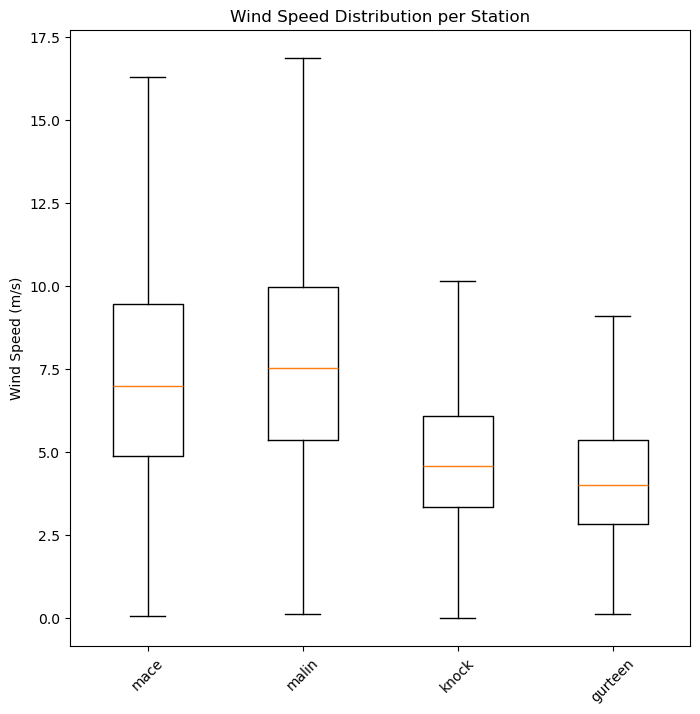

In [50]:
# Plotting boxplots
# N/As are removed with dropna to avoid miscalculations 
# Plot size:
plt.figure(figsize=(8,8))
plt.boxplot([df_weather[key]["ms_wdsp"].dropna() for key in all_stations],tick_labels=all_stations,showfliers=False)
plt.xticks(rotation=45) # Rotating text in x-axis for readability
plt.ylabel("Wind Speed (m/s)")
plt.title("Wind Speed Distribution per Station")
plt.show()

Min values for all sites is zero. 

**Mace Head:**  
Median wind speed approclose to 7m/s. Quartile ranges from about 5 to 9.5 m/s, which indicates moderate variability. Max value is close to 16 m/s.

**Malin Head:**  
Highest wind speed overall, median is around 7.5 m/s and quartile from approximately 5.5 to 10 m/s. Max values reach 17 m/s, indicating frequent strong wind events. High wind speed variability.

**Ireland West Knock Airport:**    
Median around 4.5 m/s. Quartile range is between 3.5 to 6 m/s, max values reach about 10 m/s.

**Gurteen:**    
Median close to 4 m/s and quartile ranges from 3 to 5.5 m/s. Max wind speeds reaches close to 9 m/s.

##### References:
Boxplots from multiple dictionaries: https://stackoverflow.com/questions/64169288/box-plot-a-data-from-dictionaries-key-in-python  
Including N/A values: https://stackoverflow.com/questions/79767967/making-matplotlib-boxplot-include-columns-with-nan-values  
Remove outliers for data: https://datascience.stackexchange.com/questions/54808/how-to-remove-outliers-using-box-plot  
Drop table: https://stackoverflow.com/questions/58951334/aiopg-sqlalchemy-how-to-drop-table-if-exists-without-raw-sql

### Wind farm active frequency

Wind turbine limits:  
Cut-in: ~3 m/s  
Cut-out: ~25 m/s  
Rated: ~12 m/s  

In [51]:
# Variable to store operational wind speed
active_values = []

# Loop through all stations data
for key in all_stations:
    table_name = f"{key}_data"

# Calculating percentage of operational wind speed
# Count wind speed within 3 and 24
    query6 = f""" 
    SELECT 
        COUNT(CASE WHEN ms_wdsp >= 3 AND ms_wdsp < 25 THEN 1 END) * 100.0 / COUNT(*) AS active_wind_perc
    FROM {table_name}"""
    
    # Running query on Database, loading result to a dataframe and rounding results to one decimal
    result6 = pd.read_sql(query6, conn).round(1).rename(columns={"active_wind_perc": "Active wind (%)"})
    result6["Station"] = key # Adding a new column with station names
    active_values.append(result6) # Appending each result to variable active_values

# Concatenating data from all stations into one dataframe
active_df = pd.concat(active_values, ignore_index=True)
print("\n Wind Farms Active Frequency")
print(active_df)    


 Wind Farms Active Frequency
   Active wind (%)  Station
0             93.5     mace
1             94.7    malin
2             82.0    knock
3             71.0  gurteen


##### References: 

Wind turbine limits: https://www.nyserda.ny.gov/-/media/Project/Nyserda/Files/Publications/Research/Biomass-Solar-Wind/NY-Wind-Energy-Guide-1.pdf, pp.5  
pd.DataFrame.from_dict function: https://builtin.com/data-science/dictionary-to-dataframe#:~:text=pandas.-,DataFrame.,parsed%20as%20a%20DataFrame%20row.  
Rename columns: https://stackoverflow.com/questions/77692966/pandas-rename-columns-based-on-lookup-table   

In [52]:
# Debugging, see windspeed and wind power results
# pd.read_sql("SELECT ms_wdsp, wind_power FROM mace_data LIMIT 5;", conn)

### Wind farm downtime frequency

In [53]:
# Variable to store downtime values
downtime_values = []

# Loop through all stations data
for key in all_stations:
    table_name = f"{key}_data"

# Calculating percentage of downtime
# Count when windspeed is < 3 or >= 25
    query = f""" 
    SELECT 
        COUNT(CASE WHEN ms_wdsp < 3 THEN 1 END) * 100.0 / COUNT(*) AS light_wind_perc,
        COUNT(CASE WHEN ms_wdsp >= 25 THEN 1 END) * 100.0 / COUNT(*) AS strong_wind_perc
    FROM {table_name}"""
    
    # Running query on Database, loading result to a dataframe and rounding results to one decimal
    result = pd.read_sql(query, conn).round(1).rename(columns={"light_wind_perc": "Light wind (%)","strong_wind_perc":"Strong Wind (%)"})
    result["Station"] = key # Adding a new column with station names
    downtime_values.append(result) # Appending each result to variable downtime_values

# Concating data from all stations to one dataframe
downtime_df = pd.concat(downtime_values, ignore_index=True)
print(downtime_df)    

   Light wind (%)  Strong Wind (%)  Station
0             6.4              0.0     mace
1             5.3              0.0    malin
2            17.9              0.0    knock
3            28.9              0.0  gurteen


##### References:

SQL count query: https://www.interviewquery.com/p/sql-count-case-when  
Fixing error "unterminated f-string literal": https://stackoverflow.com/questions/68025686/how-to-do-python-f-strings-in-triple-quotes  
Round statement: https://stackoverflow.com/questions/76649671/how-do-i-round-the-numbers-in-a-df-column-correctly-in-python  
Appending reults to DF and concat: https://stackoverflow.com/questions/18107953/how-to-create-a-large-pandas-dataframe-from-an-sql-query-without-running-out-of  

### Active vs Downtime frequency plot

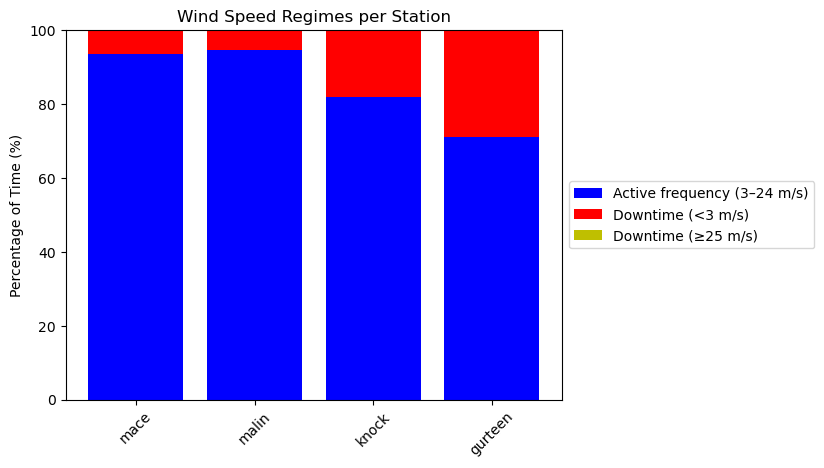

In [54]:
# Plotting variables, accessing data from dataframesactive and downtime frequency
stations = active_df["Station"]
active_freq = active_df["Active wind (%)"]
calm_freq = downtime_df["Light wind (%)"]
strong_freq = downtime_df["Strong Wind (%)"]

# Plotting stacked bar plot
plt.bar(stations, active_freq,color="b") # Active frequency (bottom)
plt.bar(stations, calm_freq,bottom=active_freq,color="r") # Calm wind(middle)
plt.bar(stations,strong_freq,bottom=active_freq + calm_freq,color="y")# Strong wind (top)

plt.ylabel("Percentage of Time (%)")
plt.title("Wind Speed Regimes per Station")
plt.xticks(rotation=45)
plt.legend(["Active frequency (3–24 m/s)","Downtime (<3 m/s)","Downtime (≥25 m/s)"],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

No downtime from strong winds (≥25 m/s)

##### Reference: 
https://www.geeksforgeeks.org/python/create-a-stacked-bar-plot-in-matplotlib/

### Seasonal average wind speed

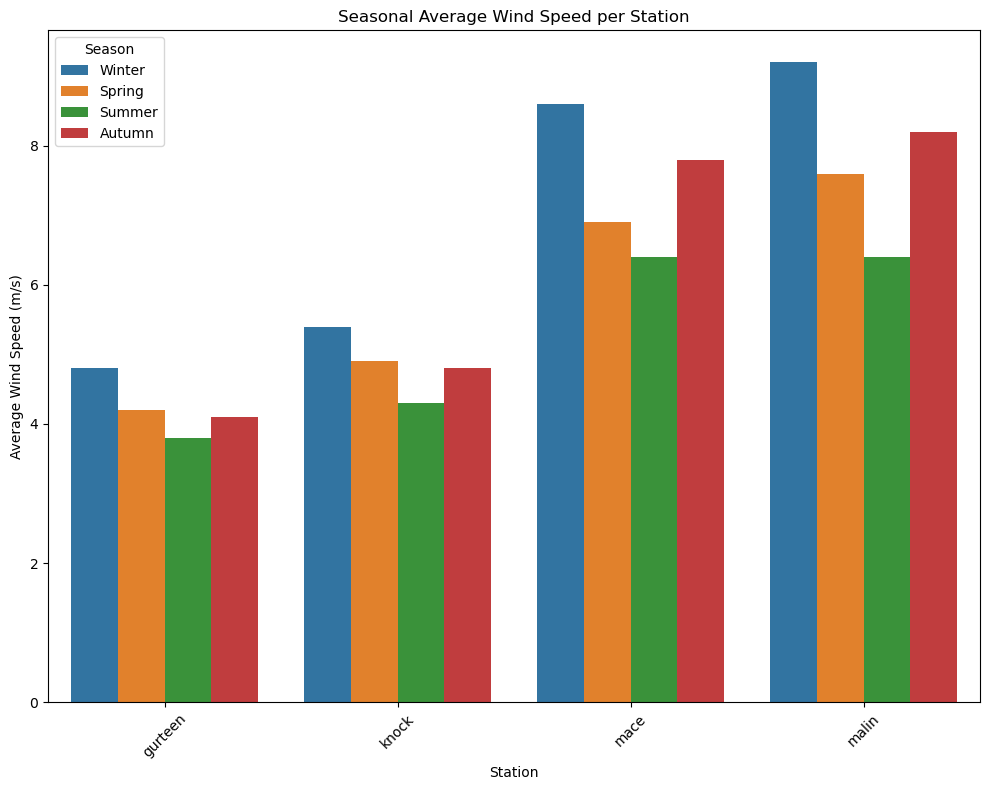

In [55]:
# Variable to store wind speed by season
season_wdpw = []
seasons = ["Winter", "Spring", "Summer", "Autumn"]

# Plot size:
plt.figure(figsize=(10,8))

# Loop through stations from all_stations
for key in all_stations:
    # Getting table names to be looped through, station name + _data
    table_name = f"{key}_data"

    # Query to calculate wind power by season
    # Each season is divided by its correspondent month number, strftime fetches the month portion of the date
    query1 = f"""
    SELECT 
        CASE 
            WHEN strftime("%m", date) IN ("12","01","02") THEN "Winter"
            WHEN strftime("%m", date) IN ("03","04","05") THEN "Spring"
            WHEN strftime("%m", date) IN ("06","07","08") THEN "Summer"
            ELSE "Autumn"
        END AS season,
        AVG(ms_wdsp) AS avg_season
    FROM {table_name}
    GROUP BY 
        CASE 
            WHEN strftime("%m", date) IN ("12","01","02") THEN "Winter"
            WHEN strftime("%m", date) IN ("03","04","05") THEN "Spring"
            WHEN strftime("%m", date) IN ("06","07","08") THEN "Summer"
            ELSE "Autumn"
        END
    """

    # Running query on Database, loading result to a dataframe and rounding results to one decimal
    result1 = pd.read_sql(query1, conn).round(1)
    result1["Station"] = key # Adding a new column with station names
    season_wdpw.append(result1) # Appending each result to variable season_wdpw

# Concatenating data from all stations into one dataframe
season_df = pd.concat(season_wdpw, ignore_index=True)

# Pivoting data for visualization
season_pvt = season_df.pivot(index="Station", columns="season", values="avg_season")

# Turning station from index to a normal column
season_pvt = season_pvt.reset_index()
# print(season_pvt)

# Reshapinh table for plotting, turns table with multiple columns into one column
season_plot = season_pvt.melt(id_vars="Station", value_vars=seasons, var_name="season", value_name="AvgWindSpeed")

# Plotting bar plot
sb.barplot(data=season_plot,x="Station",y="AvgWindSpeed",hue="season")

plt.ylabel("Average Wind Speed (m/s)")
plt.title("Seasonal Average Wind Speed per Station")
plt.xticks(rotation=45)
plt.legend(title="Season")
plt.tight_layout()
plt.show()


Wind speeds are stronger during Winter, followed by Autumn and Spring, and weakest wind speeds are in Summer at all sites.

##### References:

Code inspiration SQL query: https://stackoverflow.com/questions/51250537/case-when-expression-for-dates-in-sql-query  
Code inspiration 2 SQL query:https://stackoverflow.com/questions/650480/get-month-from-datetime-in-sqlite  
Fixing error "no such column: season" Group by SQL : https://www.geeksforgeeks.org/sqlite/sqlite-group-by-clause/  
Pivot data: https://www.influxdata.com/blog/pandas-pivot-tutorial/#:~:text=index:%20The%20index%20parameter%20sets,Here's%20a%20detailed%20breakdown:  
Reset index: https://www.dataquest.io/blog/tutorial-reset-index-in-pandas/  
Reset index: https://stackoverflow.com/questions/40914200/can-i-assign-a-reset-index-a-name  
Multiple barplots: https://stackoverflow.com/questions/38807895/seaborn-multiple-barplots  
Pandas .melt: https://medium.com/@whyamit101/what-is-pandas-melt-and-why-is-it-useful-90ea8797028a  

#### Seasonal Power vs Downtime

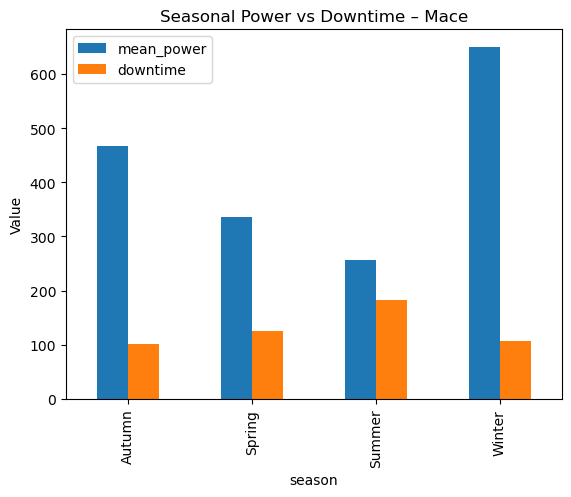

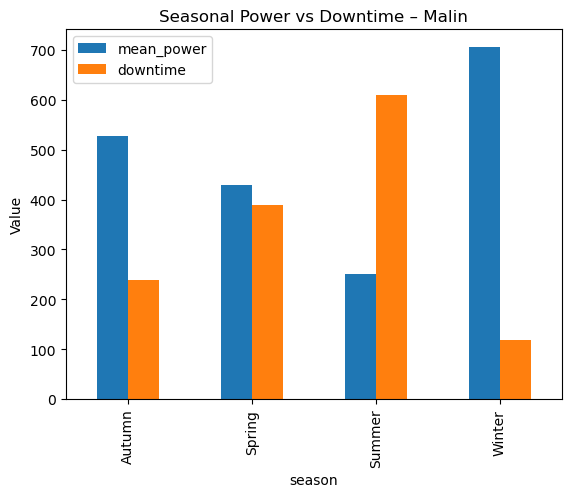

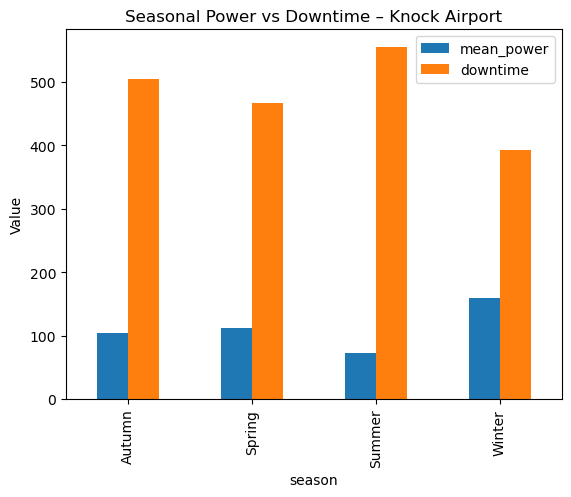

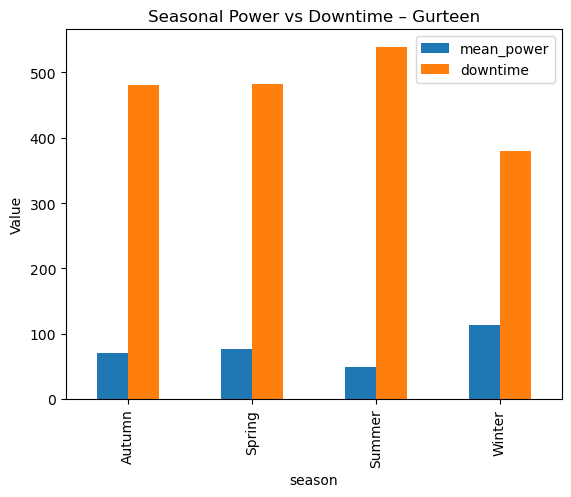

In [56]:
# Looping through all sites
for i in range(len(all_stations)):
    station = all_stations[i]
    label = labels[i]
    table_name = f"{station}_data"

    # SQL fetches wind power, calculates it's average, sum downtime values and group data by season
    query7 = f"""
    SELECT
        CASE
            WHEN strftime('%m', date) IN ('12','01','02') THEN 'Winter'
            WHEN strftime('%m', date) IN ('03','04','05') THEN 'Spring'
            WHEN strftime('%m', date) IN ('06','07','08') THEN 'Summer'
            ELSE 'Autumn'
        END AS season,
        AVG(wind_power) AS mean_power,
        SUM(CASE 
            WHEN ms_wdsp < 3 OR ms_wdsp > 25 THEN 1 
            ELSE 0 
        END) AS downtime
    FROM {table_name}
    GROUP BY season
    """

    # Running query
    pwr_downt = pd.read_sql(query7, conn)

    # Plotting downtime, season as the x-axis values
    pwr_downt.set_index("season").plot(kind="bar")
    plt.title(f"Seasonal Power vs Downtime – {label}")
    plt.ylabel("Value")
    plt.show()

**All locations:**
Winter has the lowest downtime and highest mean power while Summer is the opposite. Winter is the best season for Wind Farms energy production.

**Mace Head**

At Mace, mean power is the highest in winter, around 650, with downtime of about 100. Mean power is higher than downtime across all seasons.

**Malin Head**
Very high power in winter, approximately 700, followed by autumn as well, near 500. Summer's downtime of 600 is significantly higher than mean power which is around 250. A surprising result for a location with overall operational time of almost 95%

**Knock Airport & Gurteen**
In both locations, the seasonal downtime is considerably higher then mean power, the highest mean power values happen during Winter, aproximately 180 and 100 respectively and downtime surpasses 500 in Summer.

### Seasonal heatmap

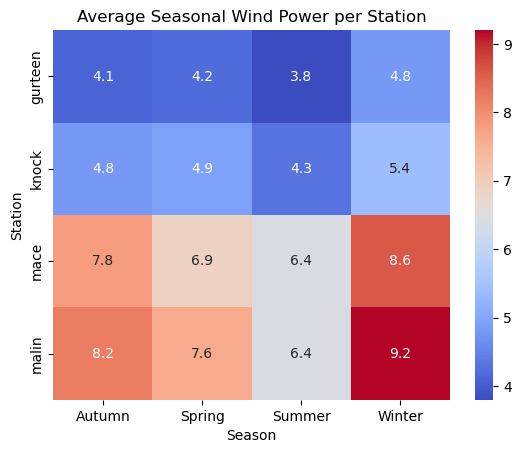

In [57]:
# Printing heatmap
sb.heatmap(season_pvt.set_index("Station"), fmt=".1f", annot=True, cmap="coolwarm")
plt.title("Average Seasonal Wind Power per Station")
plt.ylabel("Station")
plt.xlabel("Season")
plt.show()

This heatmap shows a clear contrast in wind power between Mace/Malin and Knock/Gurteen, noticeable from the warm (strong) to cool (weak) colors. The warm colors prevail Malin Head and Mace Head, especially in winter, where deep red tones are visible, indicating the highest wind powers across all sites with Malin being the strongest. The next highest wind class are the Orange tones, predominant in Autumn and Spring for Malin. Only blue tones in Summer showing the discrepancy in power between Summer and Winter.
Knock Airport and Gurteen appear entirely by cool colors from dark to light blue, which indicates low to moderate wind power throughout the year. 

##### References:  
Heatmap: https://indianaiproduction.com/seaborn-heatmap/  
Remove long numbers from heatmap, one decimal place: https://stackoverflow.com/questions/54506626/how-to-understand-seaborns-heatmap-annotation-format

### Station trends

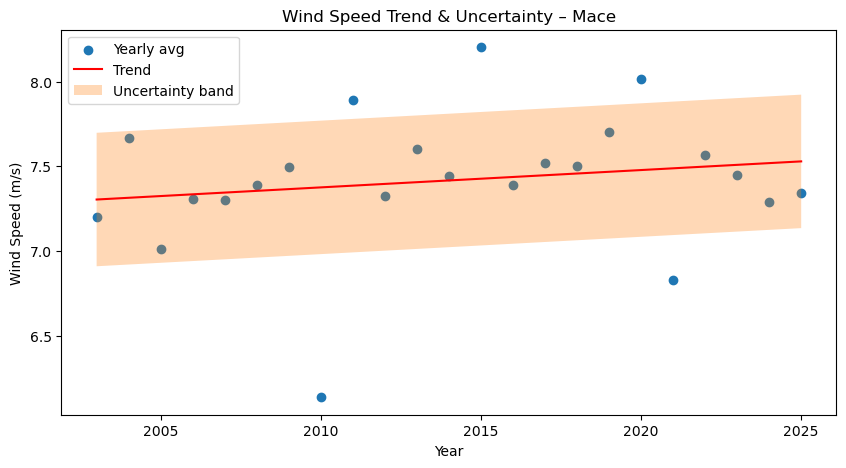

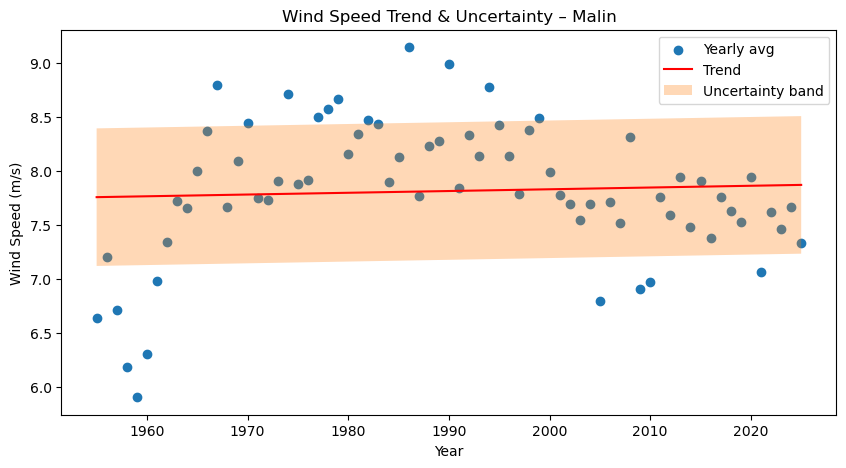

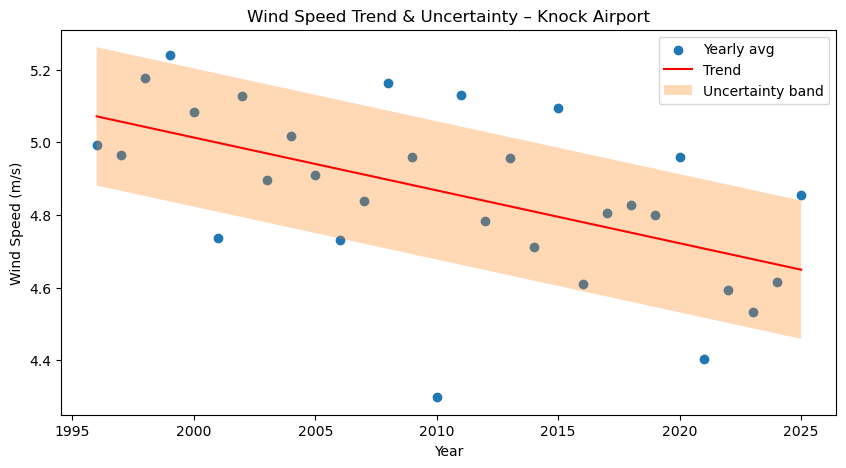

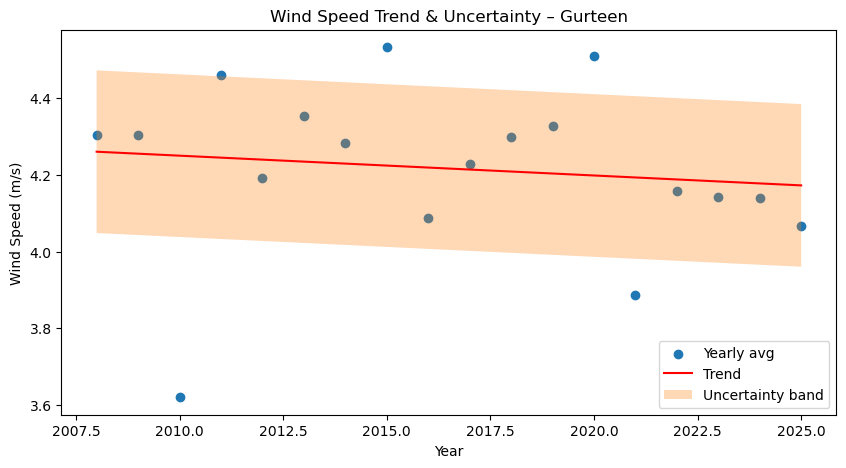

In [58]:
# Loop through stations
for i in range(len(all_stations)): #Loop throught the length of the data, number of times to loop through
    station = all_stations[i] # Get the weather station at a determined position, first loop will fetch data from position 0 and so on
    label = labels[i] # Same as above but with labels
    
    # Grouping date and wind speed
    yearly_mean = df_weather[station].groupby(df_weather[station]["date"].dt.year)["ms_wdsp"].mean().dropna()
    
    # Fetching years for x-axis
    x = yearly_mean.index.values

    # Fecthing yearly mean wind speeds for y-axis
    y = yearly_mean.values
    
    # Finding best fit straight line
    coeffs = np.polyfit(x, y, 1)

    # Getting slope of the line
    trend = coeffs[0] 

    # Calculate values of line at each year
    y_fit = np.polyval(coeffs, x) 
    
    # Find how far the data is from the line
    residuals = y - y_fit

    # How much data varies 
    sigma = residuals.std()

    # Plot size:
    plt.figure(figsize=(10,5))

    # Plotting data
    plt.scatter(x, y, label=f"Yearly avg")
    plt.plot(x, y_fit,color= "red",label="Trend")
    plt.fill_between(x, y_fit - sigma, y_fit + sigma, alpha=0.3,label="Uncertainty band")

    plt.title(f"Wind Speed Trend & Uncertainty – {label}")
    plt.xlabel("Year")
    plt.ylabel("Wind Speed (m/s)")
    plt.legend()
    plt.show()

**All stations:**
The trend lines are only slightly sloped, and the uncertainty bands are wider than the trends. Most recorded data falls inside the uncertainty band, meaning their variability is within normal range from the trend. If the current trend continues only small variations are likely to happen.

**Mace Head**
The trend slightly upward, wind speeds increased a little over the years. Yearly averages stay mostly between approximately 7 and 8 m/s. If the trends continue, the wind speed in this location is likely to suffer a slight increase.  

**Malin Head:**  
Stable pattern, very small trend upward, shown by the almost flat red line. Recorded wind speeds were higher in earlier years, above 8 m/s, and after the 2000s, between 7 to 7.8 m/s knots, contributing to the nearly flat trend. The wind speed in this location probably won't change significantly, winds are stable and strong. 

**Ireland West Knock Airport:**  
Downward trend in wind speed over the years represented by the red line declining from approximately 5.1 to 4.6 m/s. The winds weakened here over time at the site. The wind speed could potentially decrease slightly.

**Gurteen:**  
Also a downward trend, but not as steep as Knock's. The trend ranges around 4.2 to 4 m/s. Higher wind speeds until 2020, after that no wind speeds above trend recorded. Wind speeds in this site are likely to slightly decrease or remain the same. 

##### Reference: 
https://medium.com/@amit25173/understanding-numpy-polyfit-with-step-by-step-examples-78247c0a9eed

### Wind Flowers

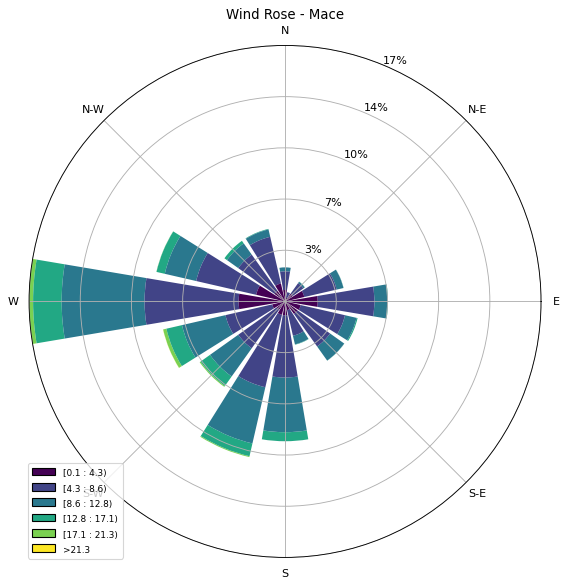

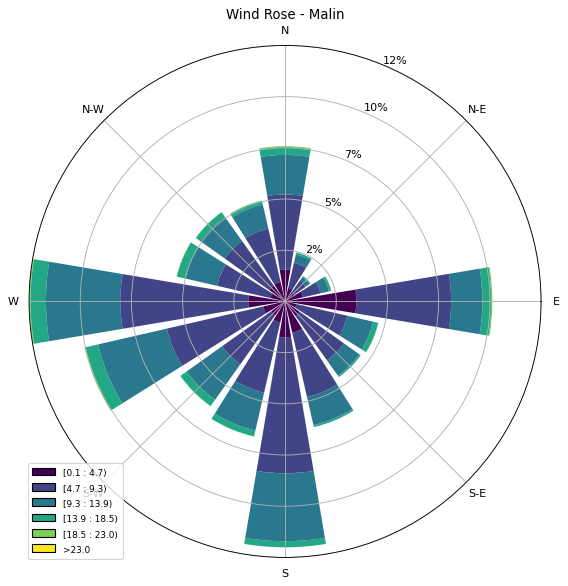

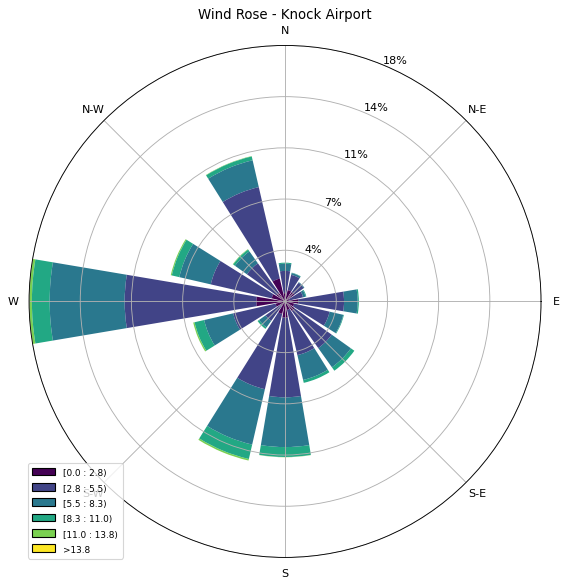

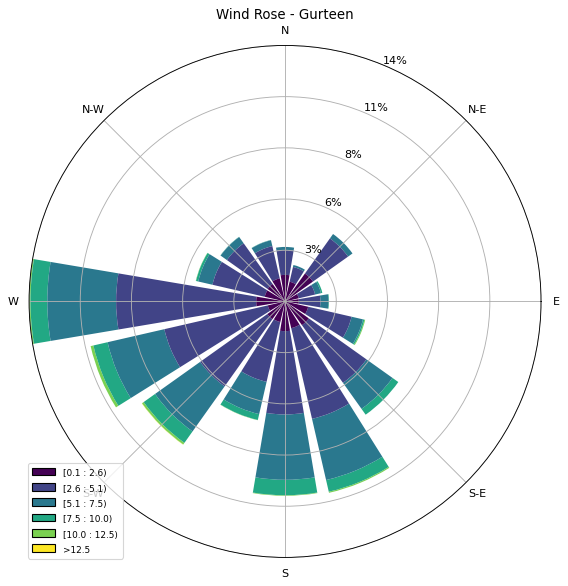

In [59]:
for i in range(len(all_stations)): #Loop throught the length of the data, number of times to loop through
    station = all_stations[i] # Get the weather station at a determined position, first loop will fetch data from position 0 and so on
    label = labels[i] # Same as above but with labels
    
    # Plotting wind roses
    ax = WindroseAxes.from_ax()
    ax.bar(df_weather[station]["ddhm"], df_weather[station]["ms_wdsp"], normed=True, opening=0.85)
    ax.set_legend()
    fmt = '%.0f%%' # Plotting percentages with no decimals
    yticks = mtick.FormatStrFormatter(fmt) #Matplotlib will use percentage format for axis labels
    ax.yaxis.set_major_formatter(yticks) # Applying percentage format to y-axis
    plt.title(f"Wind Rose - {label}")
    plt.show()

**Mace Head** west winds are the most common and strong, concentration of wind direction is concentrated between west and south. Other sectors are short and infrequent. Mace is the best site for wind farms based on wind direction only, ignoring wind speeds.  
**Malin Head**'s reveals a broader spread of wind directions but stronger and most common winds are concentrated between west and south. Highest and most common wind direction comes from the west, closely followed by southern winds. There is a noticeable frequency of Eastern wind and some Northern but not as common and strong as West/South. Malin is the best site for Wind farms based on wind direction and speed.  
**Knock Airport**, stronger domination of winds between West and South as previous sites but with less frequency or strength as petals are relatively shorter, highest and most commom wind western winds, but some significant Northeaster and Southeaster winds.  
**Gurteen** shows a broader spread of wind directions just like Malin but, with most commom concentration between West and Southeast, showing noticeable but mostly short petal, indicating weaker and more spread winds, with Western wind being the most commom and strongest.

##### References
Plot wind roses: https://medium.com/@benjamin.ganko/wind-roses-in-python-pretty-straight-forward-sort-of-d859e64c5fba

### Random Forest

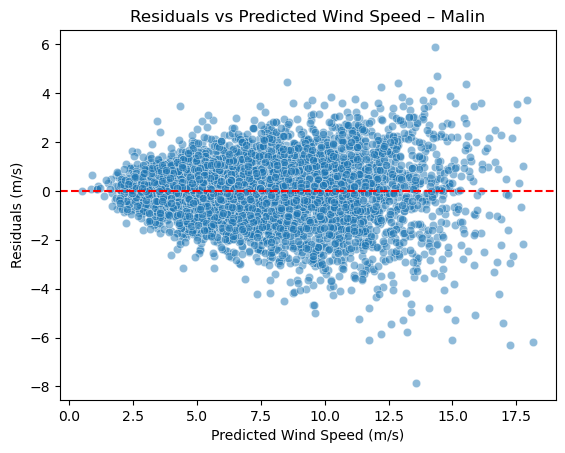

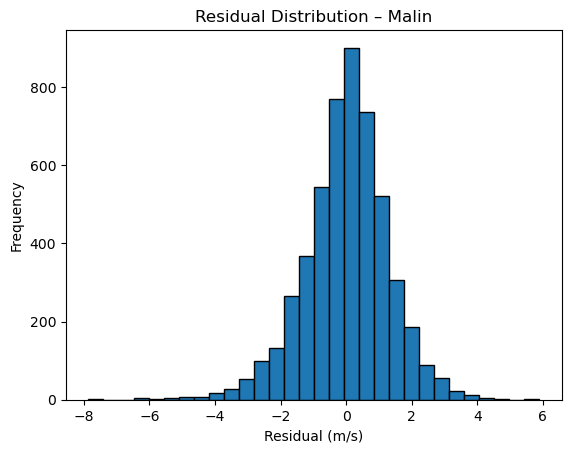

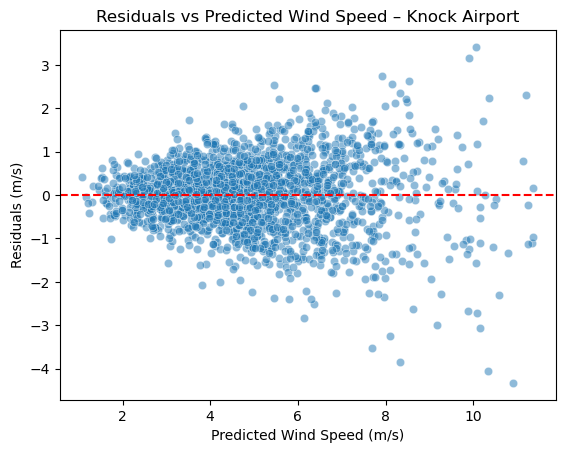

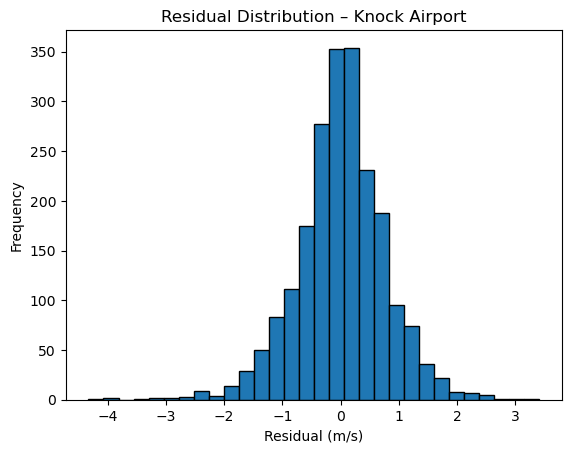

       Mean absolute error  Mean squared error        R2
malin             0.978751            1.693437  0.846978
knock             0.571660            0.601865  0.841778


In [60]:
# Variable to store results
results = {}

# Stations to be analysed
stations_class = ["malin","knock"]
labels2 = ["Malin", "Knock Airport"]

# Loop through selected stations
for i in range(len(stations_class)):
    station = stations_class[i]  
    label = labels2[i]           
    
    # Getting a copy of existing dataset for the selected station
    df = df_weather[station].copy()  
    
    # Defining features and target
    features = ["cbl", "maxtp", "mintp","hm","ddhm","hg"]  # Pressure, Air Temperature, wind gust and direction and mean wind
    target = "ms_wdsp" # Predicting wind speed
    
    # Dropping any rows with missing data for accurate analysis
    df = df.dropna(subset=features)

    # Dropping any remaining rows with missing data in the target column
    df = df.dropna(subset=[target])
    
    # Spliting data into features and target
    X = df[features]
    y = df[target]
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize model
    model = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    
    # Predictions on the test set
    y_pred = model.predict(X_test)

     # Calculating residuals, actual wind speed value vs predicted wind speed
    residuals = y_test - y_pred

    # Plotting scatter plot
    sb.scatterplot(x=y_pred, y=residuals, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel("Predicted Wind Speed (m/s)")
    plt.ylabel("Residuals (m/s)")
    plt.title(f"Residuals vs Predicted Wind Speed – {label}")
    plt.show()

    # Histogram 
    plt.hist(residuals, bins=30, edgecolor='black')
    plt.xlabel("Residual (m/s)")
    plt.ylabel("Frequency")
    plt.title(f"Residual Distribution – {label}")
    plt.show()
    
    # Store results metrics
    results[station] = {
        "Mean absolute error": mean_absolute_error(y_test, y_pred),
        "Mean squared error": mean_squared_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred) 
    }


# Printing results
results_df = pd.DataFrame(results).T
print(results_df)


Random Forest model used to estimate mean wind speed from other meteorological variables in two of the analyses sites. The model worked well, with R² score and mean absolute error of 0.85 and 0.98 m/s respectively at Malin Head and 0.84 and 0.57 m/s at Knock Airport. The  was  at Malin Head and  at Knock, which indicated consistency between predicted and observed wind speeds.Knock Airport presents lower error suggesting a higher relation to the variables in the prediction.
The residual analysis show errors mostly centered to zero, but small number of larger residuals are visible at higher wind speeds, meaning the model is predictible but more uncertain as weind speed increases. The histogram show a slighly simetric distribution als centered close to zero

##### References:  
https://medium.com/@prathik.codes/mastering-randomforestregressor-in-scikit-learn-a-practical-guide-ba8615097100
https://ryanandmattdatascience.com/random-forest-regressor/
https://towardsdatascience.com/understanding-random-forest-using-python-scikit-learn/
https://www.datacamp.com/tutorial/random-forests-classifier-python  
Features and target: https://chatgpt.com/share/695dc8d0-2d8c-8006-8cd7-b4c5b477044a  
Error "#estimators-that-handle-nan-values": https://medium.com/@whyamit101/understanding-and-customizing-dropna-for-different-use-cases-2c16973cb3b3  
Residual scatterplot: https://medium.com/@pacosun/under-the-hood-of-linear-regression-c9bf660c10ec